# 1. k-Means
*Reference: [Scikit-Learn - k-Means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)*

## 1.1. The algorithm
Given a dataset of $n$ observations $(\mathbf{o}_1,\mathbf{o}_2,\dots,\mathbf{o}_n)$.

- Step 1: Initialize the centroid for $k$ clusters by randomly selecting $k$ points from the dataset.
- Step 2: Assign data points to the nearest centroid, using Euclidean distance. This is also known as the Expectation step.
- Step 3: Update new centroids to be the mean of the clusters. This is also known as the Maximization step.
- Step 4: Repeat step 2 and 3 until the a stopping condition is met. Available stopping criteria are (1) the maximum of iterations and (2) the converage tolerance value.

## 1.2. Implementation

Notable hyperparameters:

Hyperparameter|Meaning|Default value|Common values|
:---|:---|:---|:---|
`n_clusters`|Number of clusters|`8`||
`n_init`|Number of time choosing different centroids|`10`||
`max_iter`|Maximum number of iterations for a single run.|`300`||

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-deep')
sns.set_style('whitegrid')

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [10]:
df = pd.read_csv('data/mall_customers.csv')
df.head()

,customer_id,gender,age,annual_income,spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [11]:
X = df[['annual_income','spending_score']]

In [12]:
km = KMeans(n_clusters=5)
label = km.fit_predict(X)
result = X.assign(label=label)
result.head()

,annual_income,spending_score,label
0,15,39,4
1,15,81,3
2,16,6,4
3,16,77,3
4,17,40,4


In [13]:
silhouette_score(X, label)

0.553931997444648

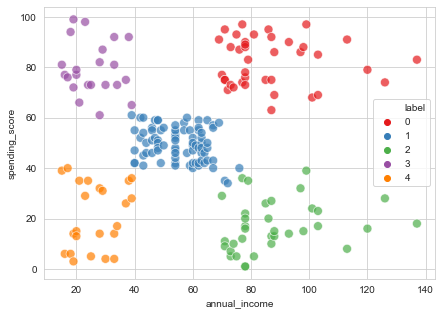

In [16]:
plt.figure(figsize=(7,5))
_ = sns.scatterplot(data=result, x='annual_income', y='spending_score', hue='label', palette='Set1', alpha=.7, s=80)

#### Determining the number of clusters
The Elbow method (which is actually grid search) plots the model evaluation score against different values of $k$. However, some evaluation metrics are monotonic functions with respect to $k$, and this leads to a situation that each cluster contains a single point only. When facing such a bad case, $k$ should be choosen at the point that model score no longer changes dramatically.

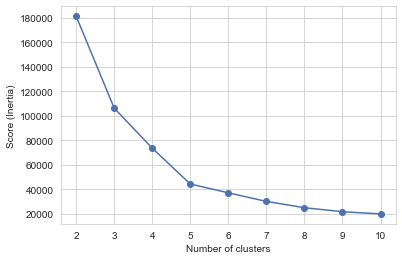

In [40]:
ks = range(2, 11)
scores = [KMeans(n_clusters=k).fit(X).inertia_ for k in ks]

plt.plot(ks, scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Score (Inertia)')
plt.show()

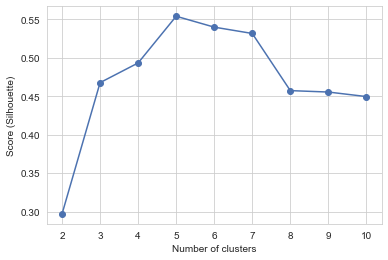

In [39]:
ks = range(2, 11)
scores = []
for k in ks:
    km = KMeans(n_clusters=k)
    label = km.fit_predict(X)
    score = silhouette_score(X, label)
    scores.append(score)

plt.plot(ks, scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Score (Silhouette)')
plt.show()

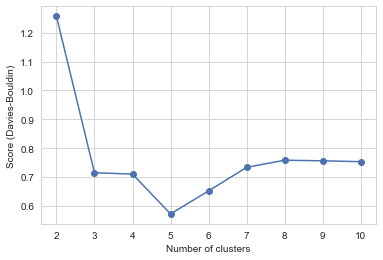

In [42]:
ks = range(2, 11)
scores = []
for k in ks:
    km = KMeans(n_clusters=k)
    label = km.fit_predict(X)
    score = davies_bouldin_score(X, label)
    scores.append(score)

plt.plot(ks, scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Score (Davies-Bouldin)')
plt.show()

# 2. Mean Shift
*Reference: [Scikit-Learn - Mean Shift](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html)*

## 2.1. The algorithm
Mean Shift is a non-parametric, density-based algorithm which uses the concept of Kernel Density Estimation mentioned in topic *[Seaborn] Data Visualization*. The main idea of Mean Shift is to place a Gausian kernel (a special case of RBF function) on each data point and then add them up. This process results in *local maxima*, each represents a high density area and hence becomes a cluster centroid. The kernel function used in Mean Shift has the following equation:

$$K(x) = \frac{1}{h\sqrt{2\pi}}\cdot\exp{\left(-\frac{\parallel x-x_i\parallel_2^2}{h^2}\right)}$$

Mean Shift does not require users to select the number of clusters, however the value of bandwidth $h$ needs to be set appropriately. A very small bandwidth represents peaked kernel curve and tends to make each data point a cluster its own, while a very large bandwidth results in a single cluster containing all data points.

#### The iterative method
The algorithm to find *local maxima* of the KDE is called *mean-shift iteration*, which is ran on some random points inside the *convex hull* of the dataset. The final goal of this method is to shift those random points to highest density regions. For each point $\mathbf{o}$, implement the following steps:
- Step 1. Create a circular sliding window centered at the point $\mathbf{o}$ with the radius $h$.
- Step 2. At each iteration, shift the circle centre to the mean of all data points within the circle. This gradually shifts the centres towards the high density regions.
- Step 3. Repeat step 1 and 2 until the centre no longer moves.

Here is the illustration of how Mean Shift works:

<img src='image/mean_shift.gif' style='height:300px; margin:0 auto 20px;'>

## 2.2. Implementation

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-deep')
sns.set_style('whitegrid')

from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [18]:
df = pd.read_csv('data/mall_customers.csv')
df.head()

,customer_id,gender,age,annual_income,spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [79]:
X = df[['annual_income','spending_score']]

In [44]:
ms = MeanShift(bandwidth=25)
label = ms.fit_predict(X)
result = X.assign(label=label)
result.head()

,annual_income,spending_score,label
0,15,39,4
1,15,81,3
2,16,6,4
3,16,77,3
4,17,40,4


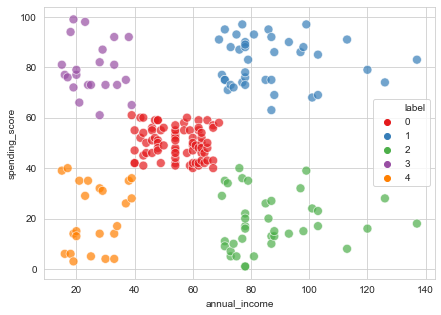

In [45]:
plt.figure(figsize=(7,5))
_ = sns.scatterplot(data=result, x='annual_income', y='spending_score', hue='label', palette='Set1', alpha=.7, s=80)

#### Estimating the bandwidth
Scikit-Learn provides the `estimate_bandwith()` function returns the best bandwidth for the dataset. Given $n$ data points $\mathbf{o}_1,\mathbf{o}_2,\dots,\mathbf{o}_n$ and a pre-defined `quantile` value $q$, $q\in(0,1]$. The bandwidth $h$ is estimated by taking the average distance between each point and its furthest neighbor among $\lfloor nq\rfloor$ nearest neighbors.

This estimation method allows users to put less effort into hyperparameter tuning, since the quantile value is usually $q\in(0.1, 0.3)$. However, finding nearest nighbors for every data point is computationally expensive, therefore this method does not scale very well. When the dataset is large, the function parameter `n_samples` should be set in order to downsample data.

In [49]:
estimate_bandwidth(X, quantile=0.17)

24.342868108278907

# 3. Agglomerative Clustering
*Reference: [Scikit-Learn - Agglomerative Clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)*

## 3.1. The algorithm
Agglomerative Clustering is a member of hierarchical clustering algorithms family. In this algorithm, each observations starts in its own cluster and at each iteration, the closest pair of clusters are merged together. Until there is a single cluster containing all data points left, the algorithm stops.

To decide the closest pair of clusters, the distances between each pairs are arranged in a matrix. There are a couple of strategies to define the distance between two clusters, they are called `linkage` criteria in Scikit-Learn.
- `linakge='single'` uses the closest pair of observations between the two clusters. This approach works well when clusters are far enough from each other and cannot separate properly if there are noises between clusters.
- `linakge='complete'` uses the furthest pair of observations between the two clusters. Being exactly oppposite to single linkage, complete linkage does pretty well when there are noises but tends to break large clusters.
- `linakge='average'` uses the average distance of all pairs of observations.
- `linkage='ward'` minimizes the variance of the clusters being merged. This method has the most stable preformance one overall and hence becomes the default linkage used in Scikit-Learn.

## 3.2. Implementation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-deep')
sns.set_style('whitegrid')

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [2]:
df = pd.read_csv('data/mall_customers.csv')
df.head()

,customer_id,gender,age,annual_income,spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [25]:
X = df[['annual_income','spending_score']]

In [13]:
ac = AgglomerativeClustering(n_clusters=5, linkage='ward')
label = ac.fit_predict(X)
result = X.assign(label=label)
result.head()

,annual_income,spending_score,label
0,15,39,4
1,15,81,3
2,16,6,4
3,16,77,3
4,17,40,4


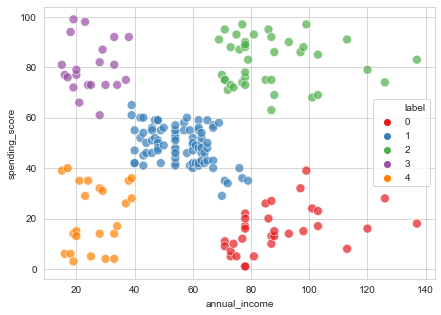

In [14]:
plt.figure(figsize=(7,5))
_ = sns.scatterplot(data=result, x='annual_income', y='spending_score', hue='label', palette='Set1', alpha=.7, s=80)

#### Dendrogram
Dendrogram is a tree-like diagram visualizes hierarchical relationship and thus can be used in Hierarchical Clustering interpreting.

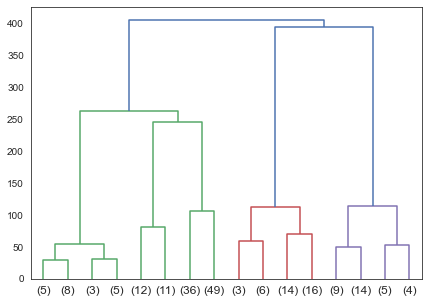

In [47]:
from scipy.cluster.hierarchy import dendrogram, linkage
sns.set_style('white')

plot_data = linkage(X, method='ward')

plt.figure(figsize=(7, 5))
dendrogram(plot_data, p=3, truncate_mode='level')
plt.show()

# 4. DBSCAN
*Reference: [Scikit-Learn - DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)*

## 4.1. The algorithm
DBSCAN, abbreviate for Density-Based Spatial Clustering of Applications with Noises, is an interesting clustering algorithm which has the ability of detecting anomaly and is able to handle non-convex clusters. With a pre-selected value of min distance ($\epsilon$) and min instances, the algorithm classifies data points into three categories:
- Core point: a point having enough neighbors within a given radius.
- Edge point: a point not qualifying as a core, but being a neighbor of another core point.
- Outlier: neither being a core nor an edge point.

DBSCAN is described in the following process:
- Step 1: Begins with a non-visited, random point. If there are at least a number of points around it within the radius $\epsilon$, this point is marked as a core point and forms a cluster with its neighbors. Otherwise, it is labeled as an outlier.
- Step 2: Determine whether each neighbor of the previous point is a core point or an edge point. If being another core point, repeat step 1 and keep extending the current cluster.
- Step 3: Repeat step 1 and 2 until all members of the current cluster have been revealed. Finish the cluster.
- Step 4: Randomize a new non-visited point, repeat step 1, 2 and 3 until all data points have been visited. At the end, each point may either belong to a cluster or be an outlier.

<img src='image/dbscan.gif' style='height:300px; margin:0 auto 20px;'>

## 4.2. Implementation

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-deep')
sns.set_style('whitegrid')

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [49]:
df = pd.read_csv('data/mall_customers.csv')
df.head()

,customer_id,gender,age,annual_income,spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [50]:
X = df[['annual_income','spending_score']]

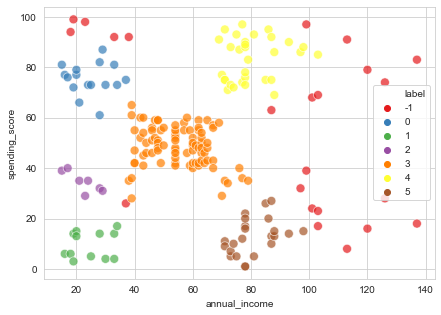

In [92]:
dbscan = DBSCAN(eps=9, min_samples=5)
label = dbscan.fit_predict(X)
result = X.assign(label=label)
# result.head()

plt.figure(figsize=(7,5))
_ = sns.scatterplot(data=result, x='annual_income', y='spending_score', hue='label', palette='Set1', alpha=.7, s=80)

# 5. Gaussian Mixture Models
*Reference: [Scikit-Learn - Gaussian Mixture Models](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html)*

## 5.1. The algorithm
Gaussian Mixture Models (GMM) is another algorithm uses the concept of Expectation-Maximization besides k-Means. GMM is way more flexible that k-Means since it uses *elipses* to define clusters instead of circles. Another advantage of GMM is the ability of predicting probability of an observation belongs to a cluster using multivariate Gaussian distribution $\mathbf{X}=(\mathbf{x}_1,\mathbf{x}_2,\dots,\mathbf{x}_k)\sim\mbox{N}(\boldsymbol{\mu},\boldsymbol{\Sigma})$ with the following probability density function:

$$f(\mathbf{x};\boldsymbol{\mu},\boldsymbol{\Sigma}) =
\frac{1}{\sqrt{(2\pi)^k|\boldsymbol{\Sigma}|}}
\cdot
\exp{\left(-\frac{1}{2}\frac{(\mathbf{x}-\boldsymbol{\mu})^{\mathrm{T}}(\mathbf{x}-\boldsymbol{\mu})}{\boldsymbol{\Sigma}}\right)}$$

For simplification purposes, this section describes how the algorithm works on a univariate dataset. Given $n$ observations $o_1,o_2,\dots,o_n$ and a pre-selected number of clusters, $k$.


1. Initilization step.
 - Select at random $k$ points from the dataset without replacement to be the means $\mu_1,\mu_2,\dots,\mu_k$ of $k$ clusters.
 - Set all cluster variances to the sample variance: $\displaystyle{\sigma_1^2=\sigma_2^2=\dots=\sigma_k^2=\frac{1}{n}\sum_{i=1}^{n}{(o_i-\bar{o})^2}}$.
 - Set all cluster weights equally: $\displaystyle{w_1=w_2=\dots=w_k=\frac{1}{k}}$. Notice that cluster weights should always sum up to 1. 
 

2. Expectation step.
 - Calculate $\displaystyle{\mathcal{L}_{ij}=\mathrm{N}(o_i\mid\mu_k,\sigma_k)}$, the likelihood that the observation $o_i$ belongs the cluster $C_j$.
 - Calculate $\displaystyle{p_{ij}=\frac{w_j\mathcal{L}_{ij}}{w_1\mathcal{L}_{i1}+w_2\mathcal{L}_{i2}+\dots+w_k\mathcal{L}_{ik}}}$, the probability that the observation $o_i$ belongs the cluster $C_j$.
 
 
3. Maximization step.
 - Update new weight $\displaystyle{w_j=\frac{1}{n}\sum_{i}^{n}{p_{ij}}}$ for cluster $C_j$.
 - Update new mean $\displaystyle{\mu_j=\frac{p_{1j}o_1+p_{2j}o_2+\dots+p_{nj}o_n}{p_{1j}+p_{2j}+\dots+p_{nj}}}$ for cluster $C_j$.
 - Update new variance $\displaystyle{\sigma_j^2=\frac{p_{1j}(o_1-\mu_j)^2+p_{2j}(o_2-\mu_j)^2+\dots+p_{nj}(o_n-\mu_j)^2}{p_{1j}+p_{2j}+\dots+p_{nj}}}$ for cluster $C_j$.


4. Repeat the expectation step and the maximization step until converged.

*Reference: [Brilliant - Gaussian Mixture Models](https://brilliant.org/wiki/gaussian-mixture-model/)*

## 5.2. Implementation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-deep')
sns.set_style('whitegrid')

from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [2]:
df = pd.read_csv('data/mall_customers.csv')
df.head()

,customer_id,gender,age,annual_income,spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
X = df[['annual_income','spending_score']]

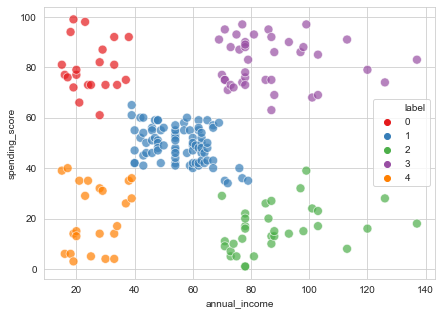

In [11]:
gmm = GaussianMixture(n_components=5)
label = gmm.fit_predict(X)
result = X.assign(label=label)
# result.head()

plt.figure(figsize=(7,5))
_ = sns.scatterplot(data=result, x='annual_income', y='spending_score', hue='label', palette='Set1', alpha=.7, s=80)

---
*&#9829; By Quang Hung x Thuy Linh &#9829;*